# Importing packages

In [65]:
from utils.plotting_functions import plot_sensor_group, dual_heat_map, pps_heat_map, scatterplot_pearson
from utils.model_summary_functions import feature_importance, metrics, summary_plot, multivariate_importance

In [66]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
import math 
import ppscore as pps
from tqdm import tqdm
import pickle
import pywt
import tensorflow as tf

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.linear_model import LassoLarsCV,LassoCV, Lasso
from sklearn.decomposition import PCA


from numpy.fft import fft, fftfreq, ifft  

from scipy import signal
from scipy.signal import welch

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances

import xgboost as xgb

import eli5
from eli5.sklearn import PermutationImportance

In [67]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [68]:
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [69]:
plt.rcParams.update({
    'font.size': 18,
    'axes.linewidth':2,
    'axes.titlesize': 20,
    'lines.linewidth' : 1.5,
    'lines.markersize' : 10,
    'figure.figsize': (25,10),
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15,
    'font.family': 'Arial',
    'legend.fontsize':14,
    'axes.labelsize':20,
    'axes.grid':True,
})

# Importing dataset after domain knowledge variables

In [70]:
df = df = pd.read_csv("Processed_data/FRA3-FRA6_cleaned.csv.zip") # Dataset from the notebook "preprocessing" 

distance = df['Distance']
df_original = df.drop(['Radius', 'Type of segment', 'Segment', 'Radius class', 'Curvature','Lat_irreg_left_rail','Lat_irreg_right_rail'],axis=1)

df_filtered = df_original.copy()
df_filtered

,Trail_right_z_sec_susp,Lead_left_z_sec_susp,Trail_left_z_sec_susp,Lead_right_z_sec_susp,Triaxial_x,Triaxial_y,Triaxial_z,Lead_z_accel_right_side,Lead_z_accel_left_side,Trail_z_accel_right_side,Trail_z_accel_left_side,Vert_irreg_right_rail,Vert_irreg_left_rail,Class,Distance
0,4.754465,-4.032296,0.384281,-0.111839,0.357634,-1.340948,0.467346,-0.137221,-0.167887,-0.376199,0.548912,0.696758,-0.758728,FRA6,1162.48
1,4.981670,-4.204004,-0.012171,0.234837,0.321047,-1.116285,0.410030,-0.214650,-0.146183,-0.228606,-0.005043,1.121480,-0.589958,FRA6,1162.73
2,5.141168,-4.374651,-0.464371,0.625782,0.290035,-0.858769,0.314448,-0.658341,-0.076193,-0.200298,-0.357206,1.487764,-0.445029,FRA6,1162.98
3,5.219155,-4.538845,-0.942159,1.013590,0.233980,-0.595780,0.198363,-0.640396,0.018844,-0.000545,-0.617920,1.749809,-0.329522,FRA6,1163.23
4,5.241801,-4.698832,-1.416210,1.373247,0.170888,-0.350346,0.074303,-0.732363,0.115630,0.127711,-0.823713,1.910538,-0.225508,FRA6,1163.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82811,0.274498,-0.771647,0.199028,-0.154884,0.022071,-0.057039,-0.002480,-0.027405,0.006964,-0.268650,0.101290,0.061025,-0.039125,FRA3,7403.98
82812,0.217612,-0.729767,0.266664,-0.188086,0.023018,-0.063244,-0.010952,-0.024495,0.009670,-0.404592,0.059867,0.066136,-0.058148,FRA3,7404.23
82813,0.163172,-0.683227,0.308563,-0.204916,0.020999,-0.068965,-0.017255,-0.021117,0.015404,-0.389629,0.013502,0.066851,-0.075040,FRA3,7404.48
82814,0.113594,-0.630599,0.321990,-0.211156,0.014219,-0.075988,-0.019855,-0.010893,0.016281,-0.249547,0.026842,0.063201,-0.088544,FRA3,7404.73


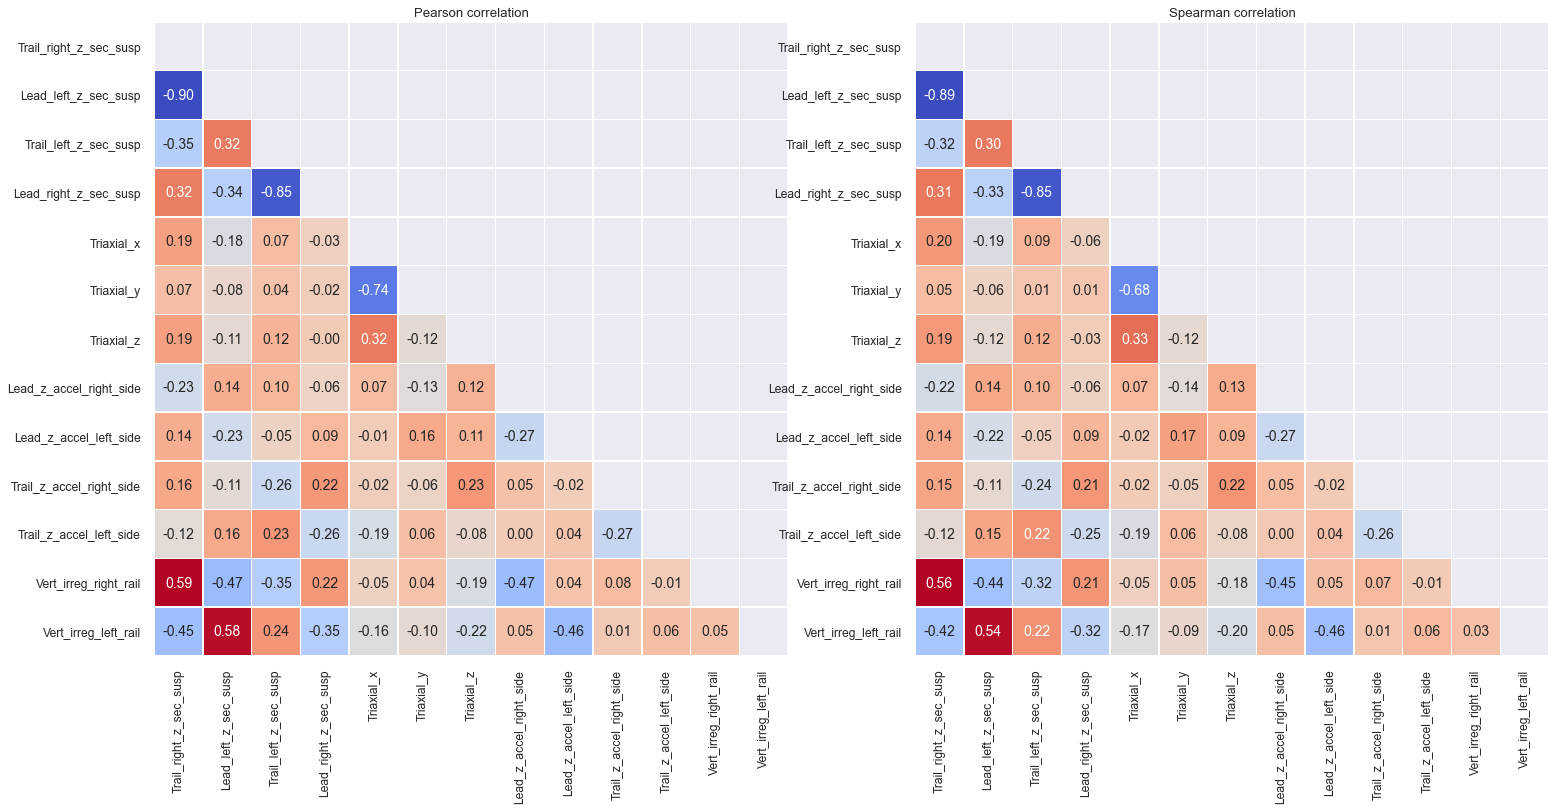

In [71]:
dual_heat_map(df_filtered.drop(['Class','Distance'],axis=1))

# Baseline model performance

In [72]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=0,shuffle=True) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [73]:
y = df_filtered['Vert_irreg_right_rail']
X = df_filtered.drop(['Vert_irreg_right_rail','Vert_irreg_left_rail','Class','Distance'],axis=1)

X_scaled_train,X_scaled_test,y_train,y_test = create_scaled_dataset(X,y)

In [74]:
%%time
mdl = RandomForestRegressor(n_estimators=100,n_jobs=1,random_state=0)
mdl.fit(X_scaled_train,y_train)
yhat=mdl.predict(X_scaled_test)
score = metrics(y_test,yhat)

MSE:5.443444118030448 
MAE:1.649986154976093 
R2:0.6909676978741768
Wall time: 53.4 s


In [75]:
#cv = KFold(n_splits=5,shuffle=True)
#summary_plot(mdl,X_scaled_train,y_train,X_scaled_test,y_test,cv,train_sizes=np.linspace(0.1,1,8))

# Time domain features - tsfresh

https://tsfresh.readthedocs.io/en/latest/text/forecasting.html

In [83]:
# The dataset is so big that it takes too long to run:

#df_filtered = df_aux.loc[(df['Class']=='FRA3')]

In [84]:
enc = LabelEncoder()

df_filtered['Class'] = enc.fit_transform(df_filtered['Class'])
df_filtered

,Trail_right_z_sec_susp,Lead_left_z_sec_susp,Trail_left_z_sec_susp,Lead_right_z_sec_susp,Triaxial_x,Triaxial_y,Triaxial_z,Lead_z_accel_right_side,Lead_z_accel_left_side,Trail_z_accel_right_side,Trail_z_accel_left_side,Vert_irreg_right_rail,Vert_irreg_left_rail,Class,Distance
0,4.754465,-4.032296,0.384281,-0.111839,0.357634,-1.340948,0.467346,-0.137221,-0.167887,-0.376199,0.548912,0.696758,-0.758728,3,1162.48
1,4.981670,-4.204004,-0.012171,0.234837,0.321047,-1.116285,0.410030,-0.214650,-0.146183,-0.228606,-0.005043,1.121480,-0.589958,3,1162.73
2,5.141168,-4.374651,-0.464371,0.625782,0.290035,-0.858769,0.314448,-0.658341,-0.076193,-0.200298,-0.357206,1.487764,-0.445029,3,1162.98
3,5.219155,-4.538845,-0.942159,1.013590,0.233980,-0.595780,0.198363,-0.640396,0.018844,-0.000545,-0.617920,1.749809,-0.329522,3,1163.23
4,5.241801,-4.698832,-1.416210,1.373247,0.170888,-0.350346,0.074303,-0.732363,0.115630,0.127711,-0.823713,1.910538,-0.225508,3,1163.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82811,0.274498,-0.771647,0.199028,-0.154884,0.022071,-0.057039,-0.002480,-0.027405,0.006964,-0.268650,0.101290,0.061025,-0.039125,0,7403.98
82812,0.217612,-0.729767,0.266664,-0.188086,0.023018,-0.063244,-0.010952,-0.024495,0.009670,-0.404592,0.059867,0.066136,-0.058148,0,7404.23
82813,0.163172,-0.683227,0.308563,-0.204916,0.020999,-0.068965,-0.017255,-0.021117,0.015404,-0.389629,0.013502,0.066851,-0.075040,0,7404.48
82814,0.113594,-0.630599,0.321990,-0.211156,0.014219,-0.075988,-0.019855,-0.010893,0.016281,-0.249547,0.026842,0.063201,-0.088544,0,7404.73


In [85]:
from tsfresh.utilities.dataframe_functions import roll_time_series
df_rolled = roll_time_series(df_filtered,
                             column_id="Class", 
                             column_sort="Distance",
                             #rolling_direction=60,
                             max_timeshift=60,
                             #min_timeshift=60
                            )

C:\Users\arthu\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:454: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 30/30 [01:33<00:00,  3.12s/it]


In [86]:
df_rolled

,Trail_right_z_sec_susp,Lead_left_z_sec_susp,Trail_left_z_sec_susp,Lead_right_z_sec_susp,Triaxial_x,Triaxial_y,Triaxial_z,Lead_z_accel_right_side,Lead_z_accel_left_side,Trail_z_accel_right_side,Trail_z_accel_left_side,Vert_irreg_right_rail,Vert_irreg_left_rail,Class,Distance,id
386984,0.000250,-0.000495,0.000254,-0.000234,0.000031,-0.000299,0.000041,0.000433,0.000009,0.000013,-0.000011,-0.002364,-0.001108,0,25.23,"(0, 25.23)"
386988,0.000250,-0.000495,0.000254,-0.000234,0.000031,-0.000299,0.000041,0.000433,0.000009,0.000013,-0.000011,-0.002364,-0.001108,0,25.23,"(0, 25.48)"
386989,0.000442,-0.000562,0.000214,-0.000190,0.000032,-0.000253,0.000107,0.000774,-0.000200,0.000023,-0.000020,-0.000739,-0.001312,0,25.48,"(0, 25.48)"
386996,0.000250,-0.000495,0.000254,-0.000234,0.000031,-0.000299,0.000041,0.000433,0.000009,0.000013,-0.000011,-0.002364,-0.001108,0,25.23,"(0, 25.73)"
386997,0.000442,-0.000562,0.000214,-0.000190,0.000032,-0.000253,0.000107,0.000774,-0.000200,0.000023,-0.000020,-0.000739,-0.001312,0,25.48,"(0, 25.73)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4947705,-0.285690,-0.054611,-0.145398,0.035248,-0.006957,-0.095292,-0.001568,0.005244,-0.005536,0.009683,-0.002170,-0.001579,0.000457,3,7412.98,"(3, 7413.98)"
4947706,-0.286143,-0.050180,-0.154774,0.045147,-0.007864,-0.082134,0.000141,0.005391,-0.005303,0.011367,-0.001964,-0.001434,0.000454,3,7413.23,"(3, 7413.98)"
4947707,-0.285923,-0.046473,-0.163174,0.054656,-0.008700,-0.068314,0.001325,0.005220,-0.004892,0.012409,-0.001396,-0.001245,0.000467,3,7413.48,"(3, 7413.98)"
4947708,-0.284851,-0.043535,-0.170306,0.063467,-0.009381,-0.053776,0.001632,0.004274,-0.004389,0.009473,-0.004569,-0.001028,0.000476,3,7413.73,"(3, 7413.98)"


In [87]:
from tsfresh import extract_features
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings, EfficientFCParameters,MinimalFCParameters

df_features = extract_features(df_rolled,
                                        column_id="id",
                                        column_sort="Distance",
                                        #column_value="Trail_right_z_sec_susp",
                                        n_jobs=1,
                                        impute_function=impute,
                                        default_fc_parameters=EfficientFCParameters(),
                                        show_warnings=True)

Feature Extraction:   0%|                                                                      | 0/5 [2:18:13<?, ?it/s]


MemoryError: 

In [ ]:
df_features

In [ ]:
y = df_filtered['Vert_irreg_right_rail']
X = df_features2

X_scaled_train,X_scaled_test,y_train,y_test = create_scaled_dataset(X,y)

%%time
mdl = RandomForestRegressor(n_estimators=100,n_jobs=1,random_state=0)
mdl.fit(X_scaled_train,y_train)
yhat=mdl.predict(X_scaled_test)
score = metrics(y_test,yhat)

# Merge data back into the original dataframe

In [ ]:
df_features['Class'] = df_features['level_0']
df_features['Distance'] = df_features['level_0']

In [ ]:
df_features['Class'] = df_features['Class'].astype(int)
df_features['Distance'] = df_features['level_0'].astype(int)

In [ ]:
df_features.drop([''])

# Exporting dataset

In [ ]:
df_aux3.to_csv('Processed_data/FRA3-FRA6_cleaned_domain_knowledge_tsfresh.csv.zip',index=False,compression="zip")